In [1]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
from collections import Counter

import sys
sys.path.append('../src')
from utils import w_label_prop
from quality_functions import eval_functions
from parse_data import parse_6dfb

N_NODES = 15801
def read_graph(path="../datasets/fb_dg_gabr"):
    graph = nx.Graph()
    for i in range(N_NODES):
        graph.add_node(i)
    for v, line in enumerate(open(path)):
        edges = map(int, line.split())
        for u in edges:
            graph.add_edge(v, u)
    return graph


def get_comm_sizes_samples(graph, n_samples=10, verbose=True):
    ans = []
    for i in tqdm(range(n_samples)):
        labels, _ = w_label_prop(graph)
        comm_sizes = list(Counter(labels).values())
        ans.append(comm_sizes)
        if i < 5 and verbose:
            print(len(comm_sizes))
            top_sizes = sorted(comm_sizes)[::-1][:5]
            print(top_sizes)
    return ans


graph_conn = parse_6dfb()
labels_conn, _ = w_label_prop(graph_conn)

100%|██████████| 10/10 [00:45<00:00,  4.50s/it]


EPS
N_nodes: 15801
N_edges: 117864
Ratio: 7.459274729447503
N_comm: 3500
UNSHUFFLED
global_density : 0.7249160078007281
local_density : 0.8019910559618229
distance_based : 0.9988064561655933
node_membership : 0.8019910559618245
SHUFFLED
global_density : 0.5169067086276816
local_density : 0.6105534875918986
distance_based : 0.9972608098107242
node_membership : 0.6105534875919002

GABR
N_nodes: 15801
N_edges: 109121
Ratio: 6.905955319283589
N_comm: 346
UNSHUFFLED
global_density : 0.5559674312676951
local_density : 0.593196148547249
distance_based : 0.994280486870431
node_membership : 0.5931961485472483
SHUFFLED
global_density : 0.5051077453285774
local_density : 0.5108973051518919
distance_based : 0.9930339374080435
node_membership : 0.5108973051518916

INF
N_nodes: 15801
N_edges: 15410
Ratio: 0.975254730713246
N_comm: 6068
UNSHUFFLED
global_density : 0.6934008568056639
local_density : 0.7583053881227481
distance_based : 0.9997445364240685
node_membership : 0.75830538812274
SHUFFLED
glob

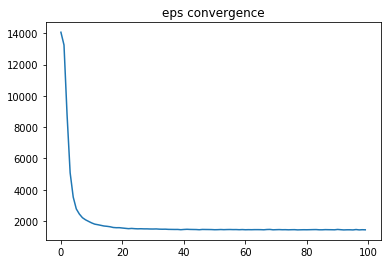

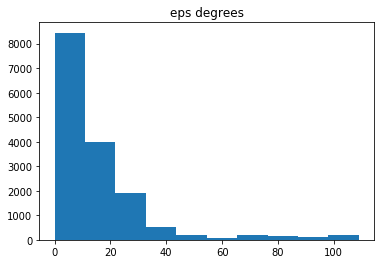

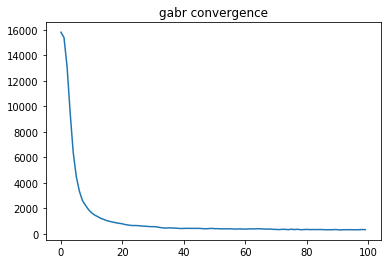

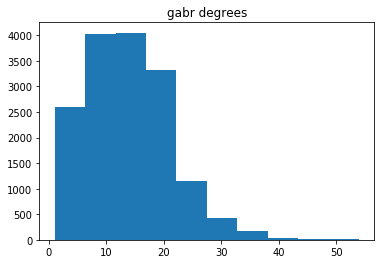

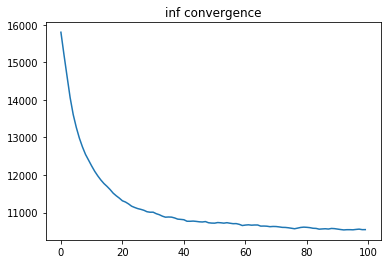

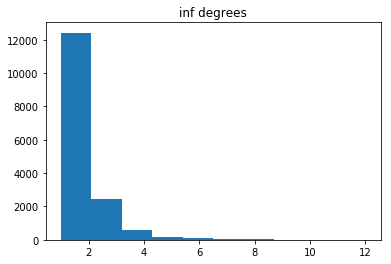

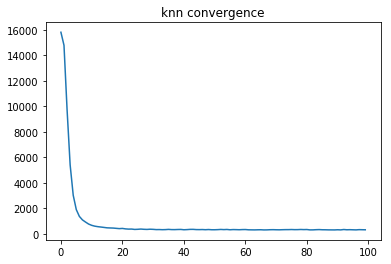

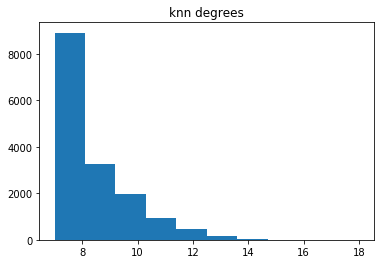

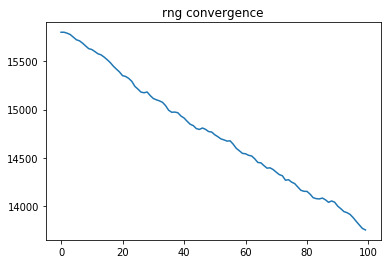

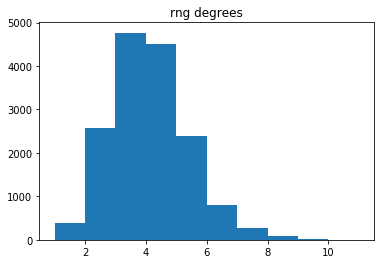

<Figure size 432x288 with 0 Axes>

In [2]:
%%time

graph_types = ['eps', 'gabr', 'inf', 'knn', 'rng']
dg_labels = dict()

for fname in graph_types:
    print(fname.upper())
    graph = read_graph('../datasets/fb_dg_' + fname)
    print("N_nodes:", graph.number_of_nodes())
    print("N_edges:", graph.number_of_edges())
    print("Ratio:", graph.number_of_edges() / graph.number_of_nodes())
    labels, deltas = w_label_prop(graph)
    dg_labels[fname] = labels
    plt.title(fname + " convergence")
    plt.plot(deltas)
    plt.figure()
    plt.title(fname + " degrees")
    plt.hist([graph.degree(i) for i in graph.nodes()])
    plt.figure()
    print("N_comm:", len(set(labels)))
    eval_functions(labels, graph)
    print()

In [3]:
def cnt_equal(array):
    cnt = dict()
    for i in array:
        if i in cnt:
            cnt[i] += 1
        else:
            cnt[i] = 1
    ans = 0
    for i in cnt.values():
        ans += (i * (i - 1)) // 2
    return ans
        

def get_n_pairs(labels_1, labels_2):
    return cnt_equal(labels_1), cnt_equal(labels_2), cnt_equal(list(zip(labels_1, labels_2)))

for fname in graph_types:
    cnt_conn, cnt_dg, cnt_common = get_n_pairs(labels_conn, dg_labels[fname])
    print(fname)
    print(cnt_conn, cnt_dg, cnt_common)
    n_pairs = N_NODES * (N_NODES - 1) // 2
    print((cnt_common * n_pairs) / (cnt_conn * cnt_dg))

eps
70210980 224435 145170
1.1499869748487659
gabr
70210980 761763 543663
1.2688682551571988
inf
70210980 30023 20306
1.2024774062908483
knn
70210980 106736 78077
1.3005253560264727
rng
70210980 206914 148353
1.2747149698540727


/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


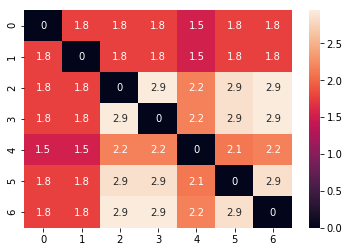

In [4]:
import seaborn as sns
import numpy as np

labels_conn_list = [labels_conn]
n_samples = 7
for i in range(n_samples - 1):
    labels_conn_list.append(w_label_prop(graph_conn)[0])
matrix = np.zeros((n_samples, n_samples))
for i in range(n_samples):
    for j in range(i + 1, n_samples):
        cnt_1, cnt_2, cnt_common = get_n_pairs(labels_conn_list[i], labels_conn_list[j])
        n_pairs = N_NODES * (N_NODES - 1) // 2
        matrix[i][j] = (cnt_common * n_pairs) / (cnt_1 * cnt_2)
        matrix[j][i] = matrix[i][j]
sns.heatmap(matrix, annot=True)

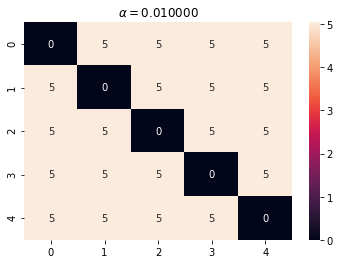

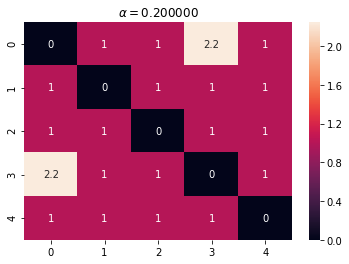

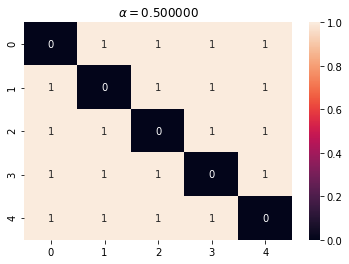

<Figure size 432x288 with 0 Axes>

In [5]:
from utils import gen_sbm_graph

for alpha in [0.01, 0.2, 0.5]:
    sbm_graph = gen_sbm_graph([100 for i in range(5)], 1 - alpha, alpha)
    labels_sbm_list = []
    n_samples = 5
    for i in range(n_samples):
        labels_sbm_list.append(w_label_prop(sbm_graph)[0])
    matrix = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            cnt_1, cnt_2, cnt_common = get_n_pairs(labels_sbm_list[i], labels_sbm_list[j])
            n_pairs = sbm_graph.number_of_nodes() * (sbm_graph.number_of_nodes() - 1) // 2
            matrix[i][j] = (cnt_common * n_pairs) / (cnt_1 * cnt_2)
            matrix[j][i] = matrix[i][j]
    plt.title("$\\alpha=%f$" % alpha)
    sns.heatmap(matrix, annot=True)
    plt.figure()

In [6]:
from pickle import dump

dump(3, open("../tmp_files/kek", "wb"))

In [7]:
from pickle import dump
with open("../tmp_files/6dfb_cd.pickle", "wb") as f:
    names = ['connections'] + graph_types
    graphs = [graph_conn]
    print("CONNECTIONS")
    samples = [get_comm_sizes_samples(graph_conn)]
    for g_type in graph_types:
        print(g_type.upper())
        dg_graph = read_graph('../datasets/fb_dg_' + fname)
        samples.append(get_comm_sizes_samples(dg_graph))
    #dump(names, f)
    dump(graphs, f)
    dump(samples, f)

  0%|          | 0/10 [00:00<?, ?it/s]

CONNECTIONS


 10%|█         | 1/10 [00:19<02:59, 19.90s/it]

2827
[8464, 4484, 10, 5, 4]


 20%|██        | 2/10 [00:40<02:41, 20.13s/it]

2831
[8458, 3287, 1190, 10, 6]


 30%|███       | 3/10 [01:01<02:22, 20.30s/it]

2829
[8348, 4591, 10, 6, 5]


 40%|████      | 4/10 [01:21<02:02, 20.42s/it]

2828
[12939, 10, 6, 5, 4]


 50%|█████     | 5/10 [01:42<01:42, 20.50s/it]

2828
[8455, 3353, 1139, 10, 6]


100%|██████████| 10/10 [03:31<00:00, 21.43s/it]


EPS


 10%|█         | 1/10 [00:13<02:04, 13.80s/it]

1385
[210, 167, 151, 146, 138]


 20%|██        | 2/10 [00:27<01:50, 13.78s/it]

1398
[175, 139, 128, 114, 111]


 30%|███       | 3/10 [00:41<01:36, 13.80s/it]

1383
[181, 116, 112, 111, 110]


 40%|████      | 4/10 [00:55<01:22, 13.80s/it]

1424
[168, 148, 137, 118, 110]


 50%|█████     | 5/10 [01:08<01:09, 13.80s/it]

1386
[319, 183, 174, 155, 132]


100%|██████████| 10/10 [02:19<00:00, 14.06s/it]


GABR


 10%|█         | 1/10 [00:13<02:04, 13.79s/it]

1396
[563, 235, 164, 130, 111]


 20%|██        | 2/10 [00:27<01:50, 13.78s/it]

1366
[169, 127, 123, 121, 112]


 30%|███       | 3/10 [00:41<01:36, 13.85s/it]

1445
[272, 150, 121, 110, 104]


 40%|████      | 4/10 [00:55<01:23, 13.95s/it]

1421
[419, 142, 126, 125, 104]


 50%|█████     | 5/10 [01:09<01:09, 13.99s/it]

1365
[246, 173, 166, 164, 152]


100%|██████████| 10/10 [02:19<00:00, 13.86s/it]


INF


 10%|█         | 1/10 [00:13<02:04, 13.80s/it]

1463
[182, 138, 108, 107, 104]


 20%|██        | 2/10 [00:27<01:50, 13.82s/it]

1400
[177, 159, 158, 130, 118]


 30%|███       | 3/10 [00:41<01:36, 13.82s/it]

1394
[163, 142, 118, 110, 105]


 40%|████      | 4/10 [00:55<01:23, 13.84s/it]

1420
[222, 167, 148, 124, 120]


 50%|█████     | 5/10 [01:09<01:09, 13.82s/it]

1400
[155, 150, 149, 114, 114]


100%|██████████| 10/10 [02:18<00:00, 13.85s/it]


KNN


 10%|█         | 1/10 [00:13<02:04, 13.87s/it]

1425
[244, 220, 153, 140, 138]


 20%|██        | 2/10 [00:27<01:51, 13.88s/it]

1387
[162, 119, 118, 112, 91]


 30%|███       | 3/10 [00:41<01:37, 13.86s/it]

1420
[207, 128, 118, 115, 108]


 40%|████      | 4/10 [00:55<01:22, 13.81s/it]

1400
[557, 142, 125, 123, 103]


 50%|█████     | 5/10 [01:09<01:09, 13.82s/it]

1458
[210, 130, 112, 101, 85]


100%|██████████| 10/10 [02:21<00:00, 14.46s/it]


RNG


 10%|█         | 1/10 [00:17<02:35, 17.24s/it]

1405
[334, 263, 140, 132, 112]


 20%|██        | 2/10 [00:31<02:09, 16.20s/it]

1412
[147, 135, 132, 107, 101]


 30%|███       | 3/10 [00:44<01:48, 15.50s/it]

1406
[339, 138, 130, 119, 116]


 40%|████      | 4/10 [00:58<01:29, 14.95s/it]

1379
[212, 161, 159, 157, 120]


 50%|█████     | 5/10 [01:12<01:13, 14.62s/it]

1339
[342, 278, 146, 125, 118]


100%|██████████| 10/10 [02:23<00:00, 14.41s/it]


In [8]:
from networkx.algorithms.components import connected_components

def comp_sizes(graph, max_c_size=20):
    comps = []
    for c in connected_components(graph):
        comps.append(len(c))
    return comps

with open("../tmp_files/6dfb_csizes.pickle", "wb") as f:
    for g_type in ['conn'] + graph_types:
        print(g_type.upper())
        if g_type != 'conn':
            graph = read_graph('../datasets/fb_dg_' + fname)
        else:
            graph = graph_conn
        sizes = comp_sizes(graph)
        print(sorted(sizes)[::-1][:10])
        dump(sizes, f)

CONN
[12970, 11, 3, 3, 3, 3, 3, 2, 2, 2]
EPS
[15801]
GABR
[15801]
INF
[15801]
KNN
[15801]
RNG
[15801]
